In [1]:
%matplotlib inline
import sys, os, time
sys.path.append("../")
sys.path.append("../web_tool/")

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

import joblib

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import rasterio
import fiona
import fiona.transform

import keras
import keras.backend as K
import keras.callbacks
import keras.utils
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
from keras.layers import Input, Dense, Activation, MaxPooling2D, Conv2D, BatchNormalization
from keras.layers import Concatenate, Cropping2D, Lambda
from keras.losses import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator

ModuleNotFoundError: No module named 'keras'

In [2]:
def get_loss(mask_value):
    mask_value = K.variable(mask_value)
    def masked_categorical_crossentropy(y_true, y_pred):
        
        mask = K.all(K.equal(y_true, mask_value), axis=-1)
        mask = 1 - K.cast(mask, K.floatx())

        loss = K.categorical_crossentropy(y_true, y_pred) * mask

        return K.sum(loss) / K.sum(mask)
    return masked_categorical_crossentropy

In [3]:
def get_model():
    K.clear_session()
    tmodel = keras.models.load_model("../web_tool/models/atumir_30.h5")
    toutput = tmodel.layers[-2].output
    toutput = Conv2D(10, (1,1), padding="same", use_bias=True, activation="softmax", name="output_conv")(toutput)
    model = keras.models.Model(inputs=tmodel.inputs, outputs=[toutput])
    
    optimizer = Adam(lr=0.001)
    model.compile(loss=get_loss([1,0,0,0,0,0,0,0,0,0]), optimizer=optimizer)
    
    return model
model = get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 14) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 150, 150, 128 16256       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 150, 150, 128 44928       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 150, 150, 128 87936       input_1[0][0]                    
____________________________________________________________________________________________

In [4]:
f = rasterio.open("../web_tool/tiles/atimur_merged.tif")
data = np.rollaxis(f.read(), 0, 3)
profile = f.profile
transform = f.profile["transform"]
src_crs = f.crs.to_string()
f.close()

In [5]:
f = fiona.open("../data/atimur_data/kdemkkmf.geojson")

coords = []
labels = []
for line in f:
    label = line["properties"]["user_label"]
    geom = fiona.transform.transform_geom(f.crs["init"], src_crs, line["geometry"])
    lon, lat = geom["coordinates"]
    y, x = ~transform * (lon, lat)
    y = int(y)
    x = int(x)
    coords.append((x,y))
    labels.append(label)
f.close()

coords = np.array(coords)
labels = np.array(labels)

In [6]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([ 36, 106,  20,  69,  80,  39,  26,  87,  94]))

In [7]:
x_train = np.zeros((coords.shape[0], 150, 150, 14), dtype=np.float32)
y_train = np.zeros((coords.shape[0], 150, 150, 10), dtype=np.uint8)
y_train[:,:,:] = [1] + [0] * (y_train.shape[-1]-1)

for i in range(coords.shape[0]):
    y,x = coords[i]
    label = labels[i]

    x_train[i] = data[y-75:y+74+1, x-75:x+74+1, :].copy()

    y_train[i,75,75,0] = 0
    y_train[i,75,75,label+1] = 1
    
x_train = x_train / 255.0

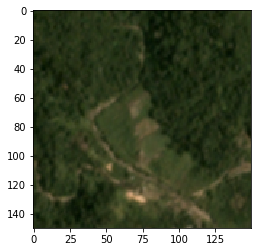

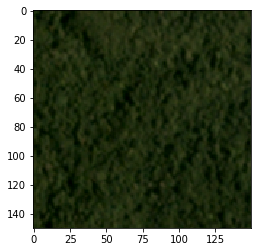

In [8]:
for i in np.random.choice(x_train.shape[0], size=2):
    
    plt.figure()
    plt.imshow(x_train[i,:,:,:3])
    plt.show()
    plt.close()

In [9]:
model.fit(
    x_train, y_train,
    batch_size=10, epochs=1, verbose=1, validation_split=0
)

Epoch 1/1
557/557 [==============================] - 126s 226ms/step - loss: 2.1501


In [11]:
x_train.shape

(1788, 150, 150, 14)

In [12]:
y_train.shape

(1788, 150, 150, 10)

In [10]:
model.save("../web_tool/models/atimur_30_TUNED1.h5")